# Imports and Functions

In [2]:
from sunlab.environment.base.cpu import *
from sunlab.environment.base.extras import *
from sunlab.globals import FILES
from sunlab.sunflow import *

In [3]:
def proximity_to(dest_arr, src, R=0.15):
    assert src.shape[-1] == dest_arr.shape[-1], f"Shape Mismatch! {src.shape}, {dest_arr.shape}"
    arrs = []
    for row in dest_arr:
        if np.linalg.norm(src-row) < R:
            arrs.append(row)
    return np.array(arrs)

def dotProduct(a,b, norm=False, axis=-1):
    if norm:
        return np.sum(a*b,axis=axis)/(np.linalg.norm(a,axis=axis)*np.linalg.norm(b,axis=axis))
    return np.sum(a*b, axis=axis)

def DistanceCovariance(model, mfv_dataset, labels=None, shuffle=False, silent=False):
    """# Distance Covariance
    Compute the distance in the MFS and MLS
    - mfv_dataset: (N,13)
    - labels: (N,...) ?"""
    from numpy import vstack, array
    from numpy.linalg import norm
    from tqdm.auto import tqdm
    assert mfv_dataset.shape[1] == 13
    if labels is None:
        neighborhood_labels = None
    else:
        assert labels.shape[0] == mfv_dataset.shape[0]
        neighborhood_labels = []
    neighborhood_distances = []
    progress = tqdm
    if silent:
        progress = lambda x: x
    for cell_index in progress(range(mfv_dataset.shape[0])):
        source_cell = mfv_dataset[[cell_index],:]
        destination_cells = vstack([mfv_dataset[:cell_index,:], mfv_dataset[(cell_index+1):,:]])
        mfv_distance = norm((destination_cells - source_cell), axis=-1)
        mlv_distance = norm((model.encoder(destination_cells)-model.encoder(source_cell)), axis=-1)
        v_distances = list(zip(mfv_distance, mlv_distance))
        if labels is not None:
            neighborhood_labels.extend([labels[cell_index,...]] * len(v_distances))
        for distance in v_distances:
            neighborhood_distances.append(distance)
    neighborhood_distances = array(neighborhood_distances)
    if labels is not None:
        neighborhood_labels = array(neighborhood_labels)
    if shuffle:
        from numpy.random import permutation as permute
        permutation = permute(neighborhood_distances.shape[0])
        neighborhood_distances = neighborhood_distances[permutation,...]
        if labels is not None:
            neighborhood_labels = neighborhood_labels[permutation,...]
    return neighborhood_distances, neighborhood_labels

def AngleCovariance(model, mfv_dataset, labels=None, filter_R=0.15, shuffle=False, silent=False):
    """# Angular Covariance
    Compute the angular mapping in the MFS and MLS
    - mfv_dataset: (N,13)
    - labels: (N,...) ?"""
    from numpy import vstack, array, ones_like
    from numpy.linalg import norm
    from tqdm.auto import tqdm
    assert mfv_dataset.shape[1] == 13
    if labels is None:
        neighborhood_labels = None
    else:
        assert labels.shape[0] == mfv_dataset.shape[0]
        neighborhood_labels = []
    neighborhood_dot_products = []
    progress = tqdm
    if silent:
        progress = lambda x: x
    for cell_index in progress(range(mfv_dataset.shape[0])):
        source_cell = mfv_dataset[[cell_index],:]
        for middle_cell_index in range(cell_index+1,mfv_dataset.shape[0]):
            middle_cell = mfv_dataset[[middle_cell_index],:]
            if norm((middle_cell - source_cell)) > filter_R:
                continue
            middle_cell_mlv = model.encoder(middle_cell)
            destination_cells = mfv_dataset[(middle_cell_index+1):,:]
            destination_cells = proximity_to(destination_cells, middle_cell, R=filter_R)
            if destination_cells.shape[0] == 0:
                continue
            comparison_vector = ones_like(destination_cells) * (middle_cell - source_cell)
            source_cell_stacks_mlv = model.encoder(ones_like(destination_cells) * source_cell).numpy()
            destination_cells_mlv = model.encoder(destination_cells).numpy()
            mfv_dot = dotProduct(comparison_vector, (destination_cells - middle_cell), axis=-1, norm=True)
            mlv_dot = dotProduct(middle_cell_mlv - source_cell_stacks_mlv,
                                 destination_cells_mlv - middle_cell_mlv, axis=-1, norm=True)
            v_dot_products = list(zip(mfv_dot, mlv_dot))
            if labels is not None:
                neighborhood_labels.extend([labels[cell_index,...]] * len(v_dot_products))
            for dot_product in v_dot_products:
                neighborhood_dot_products.append(dot_product)
    neighborhood_dot_products = array(neighborhood_dot_products)
    if labels is not None:
        neighborhood_labels = array(neighborhood_labels)
    if shuffle:
        from numpy.random import permutation as permute
        permutation = permute(neighborhood_dot_products.shape[0])
        neighborhood_dot_products = neighborhood_dot_products[permutation,...]
        if labels is not None:
            neighborhood_labels = neighborhood_labels[permutation,...]
    return np.arccos(neighborhood_dot_products), neighborhood_labels

# Setup

In [4]:
sampled_data = np.load_dat(FILES['FIGURES']['3']['SAMPLED_DATASET'])
sampled_dataset = sampled_data['dataset']
sampled_labels = sampled_data['labels']

In [5]:
model = load_aae(FILES['PRETRAINED_MODEL_DIR'], MaxAbsScaler)

In [6]:
distances, di_labels = DistanceCovariance(model, sampled_dataset, sampled_labels, shuffle=True)

  0%|          | 0/320 [00:00<?, ?it/s]

In [7]:
dots, do_labels = AngleCovariance(model, sampled_dataset, sampled_labels, shuffle=True)

  0%|          | 0/320 [00:00<?, ?it/s]

/tmp/4164832.4.sun-gpu.q/ipykernel_15252/659413713.py:102: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(neighborhood_dot_products), neighborhood_labels


In [8]:
from scipy.stats import linregress

In [9]:
linregress(distances[:,0], distances[:,1])

LinregressResult(slope=3.6509203683315596, intercept=0.08779207500439368, rvalue=0.8882295026876901, pvalue=0.0, stderr=0.005910198552333746, intercept_stderr=0.0030093420733619146)

In [10]:
linregress(dots[~np.isnan(dots).any(axis=1)][:,0], dots[~np.isnan(dots).any(axis=1)][:,1])

LinregressResult(slope=1.1799891868259695, intercept=-0.37433405991392443, rvalue=0.6360439551260989, pvalue=0.0, stderr=0.011854262020769314, intercept_stderr=0.021528236837809273)

# Runtime Parameters

In [11]:
SAVE_EXTRAS = False

In [12]:
g_Base = lambda *args: DIR_ROOT + "Figures/Invasion/"

# Plots

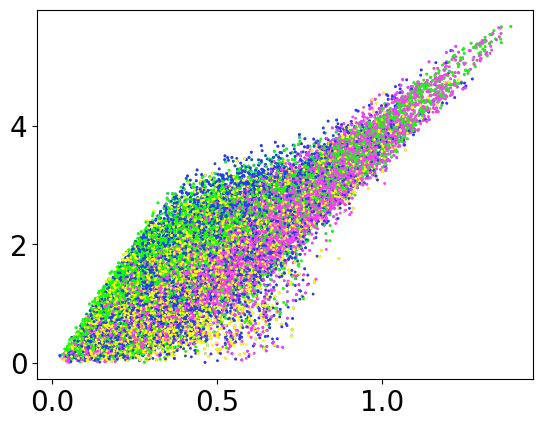

In [13]:
plt.scatter2d(distances, s=1, c=di_labels, cmap=Pmap)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Spheroid/Sampled/Distance/Colored")

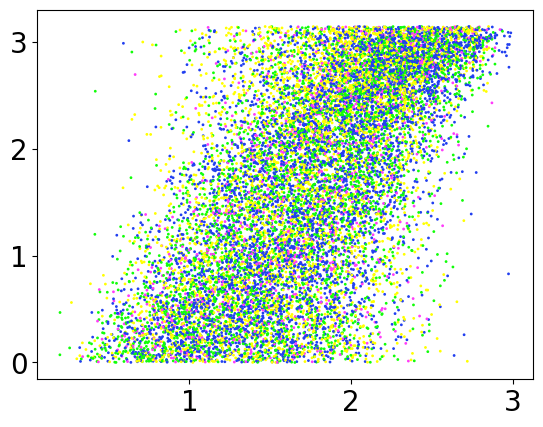

In [14]:
plt.scatter2d(dots, s=1, c=do_labels, cmap=Pmap)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Spheroid/Sampled/Angle/Colored")

In [15]:
from scipy.optimize import curve_fit
from scipy.stats import linregress

In [16]:
cos_dots = np.cos(dots)
nn_cos_dots = cos_dots[~np.isnan(cos_dots).any(axis=-1),:]

<module 'matplotlib.pyplot' from '/home/physics/cunnichr/.conda/envs/tfnb/lib/python3.9/site-packages/matplotlib/pyplot.py'>

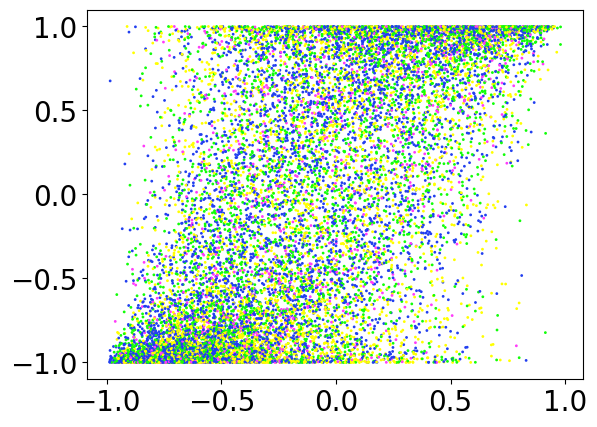

In [17]:
plt.scatter2d(cos_dots, s=1, c=do_labels, cmap=Pmap)

# Conformatlity Investigation

Text(0, 0.5, 'Conformal score')

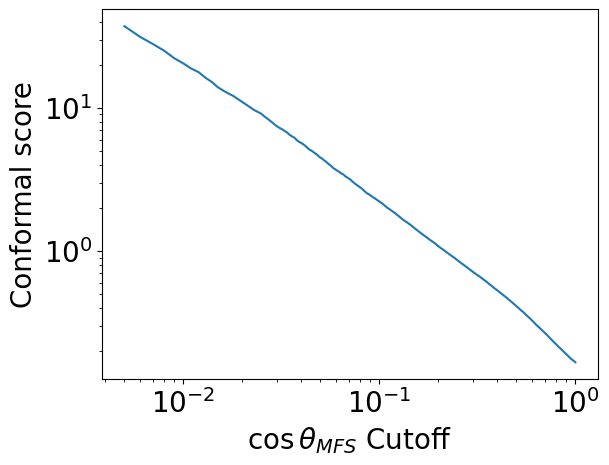

In [18]:
conformal_score = []
for window_size in np.linspace(5e-3, 1, 1000):
    _data = nn_cos_dots[np.abs(nn_cos_dots[...,0])<window_size,:]
    score = (((_data[:,0]-_data[:,1])**2.).mean()/(2*window_size))
    conformal_score.append((window_size, np.abs(score)))
conformal_score = np.array(conformal_score)

plt.plot(conformal_score[:,0],conformal_score[:,1])
plt.xscale('log')
plt.yscale('log')
# xticks = [0.5,0.6,0.7,0.8,0.9,1.0]
# plt.xticks(xticks, xticks, rotation=90)
plt.xlabel(r"$\cos\theta_{MFS}$ Cutoff")
plt.ylabel(r"Conformal score")

Text(0, 0.5, 'Conformal score')

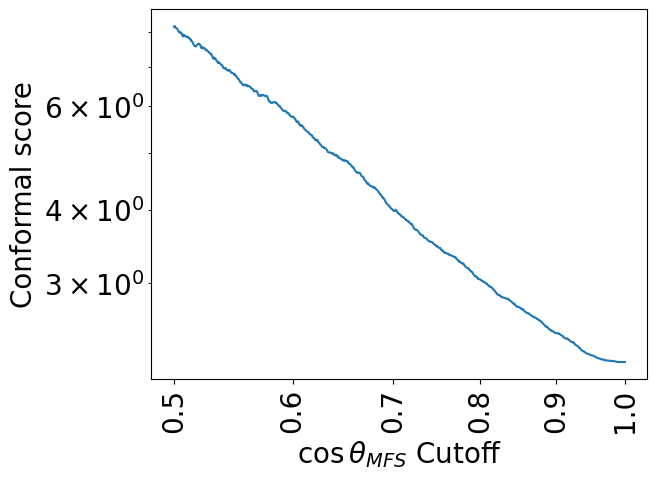

In [19]:
conformal_score = []
for window_size in np.linspace(5e-1, 1, 1000):
    _data = nn_cos_dots[np.abs(nn_cos_dots[...,0])<window_size,:]
    score = (((_data[:,0]-_data[:,1])**2.).mean()/(_data[:,0]).mean())
    conformal_score.append((window_size, np.abs(score)))
conformal_score = np.array(conformal_score)

plt.plot(conformal_score[:,0],conformal_score[:,1])
plt.xscale('log')
plt.yscale('log')
xticks = [0.5,0.6,0.7,0.8,0.9,1.0]
plt.xticks(xticks, xticks, rotation=90)
plt.xlabel(r"$\cos\theta_{MFS}$ Cutoff")
plt.ylabel(r"Conformal score")

Text(0, 0.5, '$\\left|\\frac{\\langle\\theta_{MFS}-\\theta_{MLS}\\rangle^2}{\\langle\\theta_{MFS}\\rangle}\\right|$')

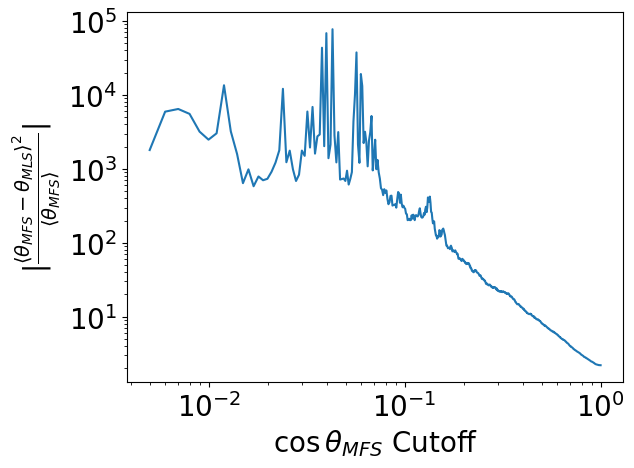

In [20]:
conformal_score = []
for window_size in np.linspace(5e-3, 1, 1000):
    _data = nn_cos_dots[np.abs(nn_cos_dots[...,0])<window_size,:]
    score = (((_data[:,0]-_data[:,1])**2.).mean()/(_data[:,0]).mean())
    conformal_score.append((window_size, (score)))
conformal_score = np.array(conformal_score)

plt.plot(conformal_score[:,0],np.abs(conformal_score[:,1]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\cos\theta_{MFS}$ Cutoff")
plt.ylabel(r"$\left|\frac{\langle\theta_{MFS}-\theta_{MLS}\rangle^2}{\langle\theta_{MFS}\rangle}\right|$")

In [21]:
theta_s = []
for window_size in np.linspace(5e-3, 1, 1000):
    _data = nn_cos_dots[np.abs(nn_cos_dots[...,0])<window_size,:]
    res = curve_fit(lambda x, a: a*x, _data[:,0], _data[:,1])
    theta_s.append((window_size, *res[0]))
theta_s = np.array(theta_s)

Text(0, 0.5, 'Slope of best fit')

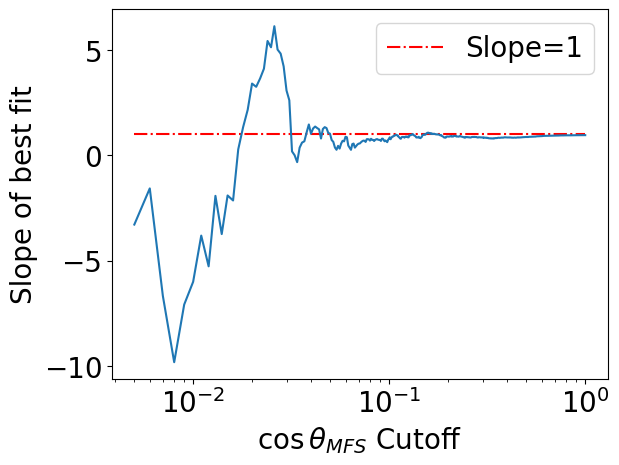

In [23]:
plt.plot([min(theta_s[:,0]),max(theta_s[:,0])],[1,1], 'r-.')
plt.legend(['Slope=1'])
plt.plot(theta_s[:,0],theta_s[:,1])
plt.xscale('log')
plt.xlabel(r"$\cos\theta_{MFS}$ Cutoff")
plt.ylabel(r"Slope of best fit")

(LinregressResult(slope=0.8301151869289547, intercept=0.08811338784610093, rvalue=0.0715843643690084, pvalue=0.0023482772114345116, stderr=0.27247533801662166, intercept_stderr=0.015546061405223134),
 array([0.79142891]))

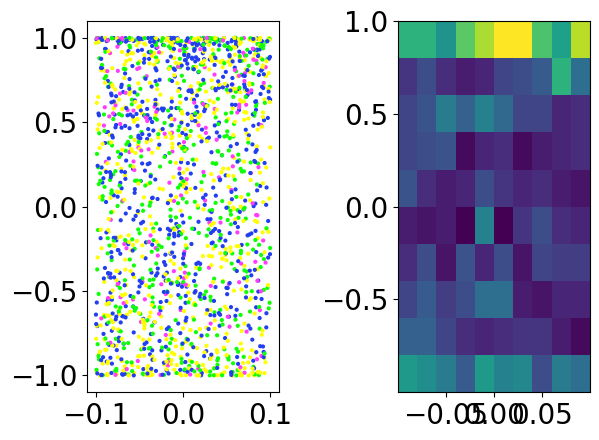

In [24]:
window_size = 1e-1
_data = nn_cos_dots[np.abs(nn_cos_dots[...,0])<window_size,:]
fig, ax = plt.subplots(1,2)
ax[0].scatter(_data[:,0], _data[:,1], c=do_labels[~np.isnan(cos_dots).any(axis=-1)][np.abs(nn_cos_dots[...,0])<window_size], cmap=Pmap, s=4)
ax[1].hist2d(_data[:,0], _data[:,1], bins=10)
plt.tight_layout()
linregress(_data[:,0], _data[:,1]), curve_fit(lambda x, a: a*x, _data[:,0], _data[:,1])[0]

In [25]:
theta_sip = []
for window_size in np.linspace(5e-3, 1, 1000):
    res = linregress(nn_cos_dots[np.abs(nn_cos_dots[...,0])<window_size,:])
    theta_sip.append((window_size, res.slope, res.intercept, res.pvalue))
theta_sip = np.array(theta_sip)

Text(0, 0.5, 'Slope of best fit')

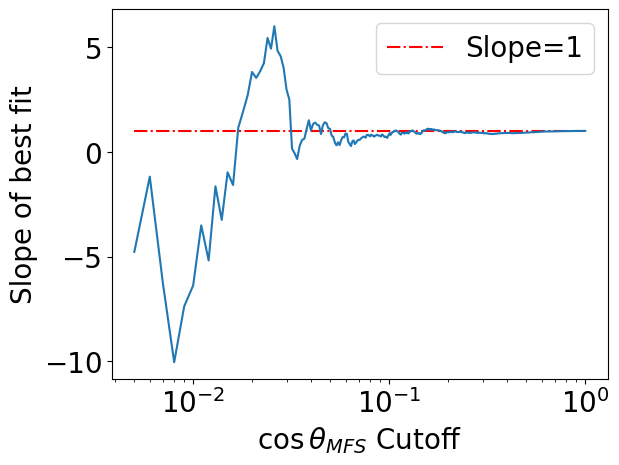

In [26]:
plt.plot([min(theta_sip[:,0]),max(theta_sip[:,0])],[1,1], 'r-.')
plt.legend(['Slope=1'])
plt.plot(theta_sip[:,0],theta_sip[:,1])
plt.xscale('log')
plt.xlabel(r"$\cos\theta_{MFS}$ Cutoff")
plt.ylabel(r"Slope of best fit")

Text(0, 0.5, 'p-value of best fit')

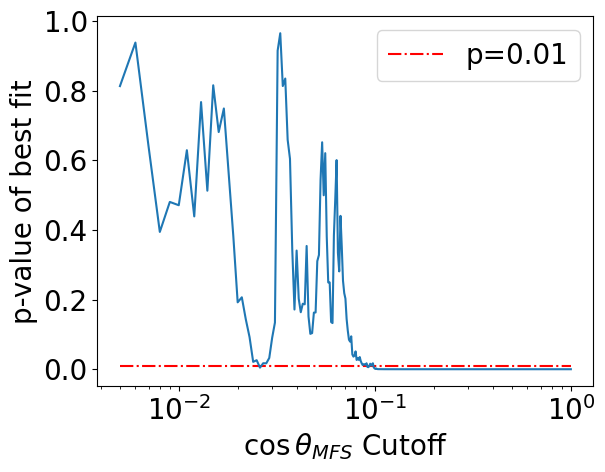

In [27]:
plt.plot([min(theta_sip[:,0]),max(theta_sip[:,0])],[0.01,0.01], 'r-.')
plt.legend(['p=0.01'])
plt.plot(theta_sip[:,0],theta_sip[:,3])
# plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$\cos\theta_{MFS}$ Cutoff")
plt.ylabel(r"p-value of best fit")

In [28]:
theta_m = []
for window_size in np.linspace(5e-3, 1, 1000):
    _filter1 = np.abs(nn_cos_dots[...,0])<=window_size
    _data = nn_cos_dots[_filter1,0] - nn_cos_dots[_filter1,1]
    theta_m.append((window_size, _data.mean(), _data.mean()+_data.std(), _data.mean()-_data.std()))
theta_m = np.array(theta_m)
theta_m

array([[ 0.005     , -0.05368014,  0.55375279, -0.66111307],
       [ 0.005996  , -0.06827164,  0.54149054, -0.67803382],
       [ 0.00699199, -0.08964667,  0.52847045, -0.70776379],
       ...,
       [ 0.99800801, -0.06852256,  0.50516665, -0.64221176],
       [ 0.999004  , -0.06852256,  0.50516665, -0.64221176],
       [ 1.        , -0.06852256,  0.50516665, -0.64221176]])

Text(0.5, 0, '$\\cos\\theta_{MFS}$ Cutoff')

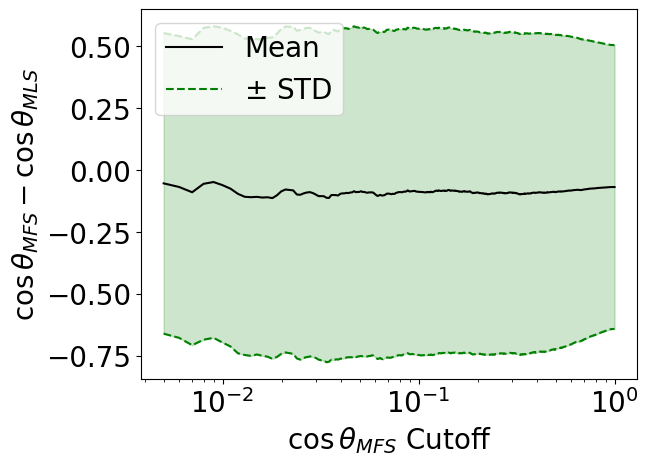

In [29]:
plt.plot(theta_m[:,0],theta_m[:,1], 'k')
plt.plot(theta_m[:,0],theta_m[:,2], 'g--')
plt.legend(['Mean', r'$\pm$ STD'])
plt.plot(theta_m[:,0],theta_m[:,3], 'g--')
plt.fill_between(theta_m[:,0],theta_m[:,2],theta_m[:,3], color='green', alpha=0.2)
plt.xscale('log')
plt.ylabel(r"$\cos\theta_{MFS}-\cos\theta_{MLS}$")
plt.xlabel(r"$\cos\theta_{MFS}$ Cutoff")

-0.06852255561040793

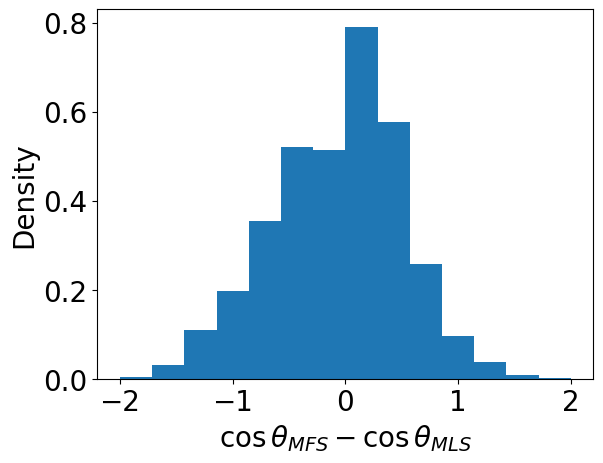

In [30]:
plt.hist(nn_cos_dots[...,0]-nn_cos_dots[...,1], bins=np.linspace(-2,2,15), density=True)
plt.xlabel(r'$\cos\theta_{MFS}-\cos\theta_{MLS}$')
plt.ylabel(r'Density')
(nn_cos_dots[...,0]-nn_cos_dots[...,1]).mean()

# END